Installo Tensorflow models.

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs
!pip install tf-models-official
!pip install gdown==4.6
!pip install imageio
!pip install codecarbon

Importo le librerie necessarie.

In [2]:
import pandas as pd
import cv2
import os
import shutil
import numpy as np
import random
from sklearn.model_selection import train_test_split
from pathlib import Path

import keras
import tensorflow as tf, tf_keras
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt

from codecarbon import EmissionsTracker

import imageio

import pickle



Scelta dei parametri:

Train = False

Questa scelta consente di scaricare i pesi della rete, in maniera tale da non dover ripetere l'addestramento.

BATCH_SIZE = 16

Indica la dimensione dei batch di video che verranno utilizzati.

EPOCHS = 30

Indica il numero di epoche

NUM_CLASSES = 3

Specifica il numero di classi che si vuole utilizzare.

NUM_FRAMES = 20

Indica il numero di frame scelti per ogni video.

RISK_CLASSIFIER = True

Questo valore, se impostato a True, avvierà il modello di classificazione dei rischi; mentre, se impostato a False, avvirà il modello di gun_classifier.

RANDOM_SEED = 42

Seed per la libreria random.

In [65]:
TRAIN = False
BATCH_SIZE = 16
EPOCHS = 30
NUM_CLASSES = 3
NUM_FRAMES = 20
RISK_CLASSIFIER = True
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

Accedo a Drive per il salvataggio dei checkpoint durante il training.

In [4]:
if TRAIN:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Scarico il dataset.

In [ ]:
if RISK_CLASSIFIER:
  !gdown "1Q7P8p9nJkSkABHLDYxpv1hxBWCJK8Bbj" -O dataset.zip #dataset rischio
else:
  !gdown "1CdEx22PRxaJ0V7gaZqvlpt9g39ty04n1" -O dataset.zip #dataset gun classifier
'''
risk classifier dataset:
"No_risk": 0,
"Medium_risk": 1,
"High_risk": 2

gun classifier dataset:
"No_Gun": 0,
"Handgun": 1,
"Machine_Gun": 2
'''
!unzip dataset.zip

Elaboro il dataset.

In [ ]:
df = pd.read_csv('dataset/class.csv')
X = df['filename']
y = df['tag']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED, shuffle = True, stratify = y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED, shuffle = True, stratify = y_temp)
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))
print(len(X_test))
print(len(y_test))
df_train = pd.DataFrame({
    'filename': X_train,
    'tag': y_train
})
df_train.to_csv('dataset/train.csv', index=False)

df_val = pd.DataFrame({
    'filename': X_val,
    'tag': y_val
})
df_val.to_csv('dataset/val.csv', index=False)

df_test = pd.DataFrame({
    'filename': X_test,
    'tag': y_test
})
df_test.to_csv('dataset/test.csv', index=False)
# Percorsi dei file CSV
train_csv_path = 'dataset/train.csv'
test_csv_path = 'dataset/test.csv'
val_csv_path = 'dataset/val.csv'
# Cartella di origine dove sono memorizzati i video
source_folder = 'dataset'

def move_videos(csv_path, destination_folder):
    # Leggi il file CSV
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    df = pd.read_csv(csv_path)
    # Itera su ogni riga del DataFrame
    for filename in df['filename']:
        # Costruisci il percorso completo del file video
        video_path = os.path.join(source_folder, filename)
        # Verifica se il file esiste
        if os.path.exists(video_path):
            # Costruisci il percorso di destinazione
            destination_path = os.path.join(destination_folder, filename)
            # Sposta il file
            shutil.move(video_path, destination_path)
            print(f"Spostato {filename} a {destination_folder}")
        else:
            print(f"Il file {filename} non esiste in {source_folder}")

# Processa i file specificati nei CSV
move_videos(train_csv_path, 'dataset/train')
move_videos(test_csv_path,'dataset/test')
move_videos(val_csv_path, 'dataset/val')
shutil.move(train_csv_path, 'dataset/train')
shutil.move(test_csv_path, 'dataset/test')
shutil.move(val_csv_path, 'dataset/val')
os.remove('dataset/class.csv')

In [ ]:
# Controllo la composizione dei vari split
file_path = ['dataset/train/train.csv', 'dataset/val/val.csv', 'dataset/test/test.csv']
for elem in file_path:
  df = pd.read_csv(elem)
  print(elem)
  print(df['tag'].value_counts())
  print('----------')

In [70]:
# resize dei frame
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

# estrazione dei frame dal video
def frames_from_video_file(video_path, n_frames, output_size = (224,224)):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """

  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  if video_length > 300:
    frame_step = 15
  else:
    frame_step = int(video_length/n_frames) - 1

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)

  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

# classe per generare batch di video e label
class FrameGenerator:
    def __init__(self, path, csv_path, n_frames, training=False):
        self.path = Path(path)
        self.path_name = path
        self.n_frames = n_frames
        self.training = training
        # Leggere il file CSV e creare un dizionario di etichette
        self.df = pd.read_csv(csv_path)
        self.label_dict = pd.Series(self.df['tag'].values, index=self.df['filename']).to_dict()
      #  print(self.label_dict)
        self.class_names = sorted(set(self.df['tag'].unique()))
        self.class_ids_for_name = {name: idx for idx, name in enumerate(self.class_names)}
        print(f"Initialized FrameGenerator with {len(self.label_dict)} labels")

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*.mp4'))
        video_names = [path.name for path in video_paths]
        classes = [self.label_dict[name] for name in video_names]
       # print(f"Found {len(video_names)} video files")  # Debugging
        return video_paths, classes

    def __call__(self):
      #  print("FrameGenerator __call__ start")  # Debugging
        video_paths, classes = self.get_files_and_class_names()
        pairs = list(zip(video_paths, classes))
      #  print(f'pairs: {pairs}')
        if self.training:
            np.random.shuffle(pairs)
        for path, label in pairs:
            video_frames = frames_from_video_file(path, self.n_frames)
           # print(f"Yielding frames for video {path} with label {label}")  # Debugging
            yield video_frames, label

In [ ]:
# creo placeholder per train, validation e test

subset_paths = {
    'train': '/content/dataset/train',
    'validation': '/content/dataset/val',
    'test': '/content/dataset/test'
}

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], '/content/dataset/train/train.csv', NUM_FRAMES, training = True),
                                          output_signature = output_signature)
train_ds = train_ds.batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['validation'], '/content/dataset/val/val.csv', NUM_FRAMES),
                                        output_signature = output_signature)
val_ds = val_ds.batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], '/content/dataset/test/test.csv', NUM_FRAMES),
                                         output_signature = output_signature)
test_ds = test_ds.batch(1)

Effettuo il download di un modello MoViNet-A0 pre-addestrato sul dataset Kinetics600.

In [ ]:
model_id = 'a0'
resolution = 224

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id=model_id)
backbone.trainable = False

model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
model.build([None, None, None, None, 3])

!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz -q
!tar -xvf movinet_a0_base.tar.gz

checkpoint_dir = f'movinet_{model_id}_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

Aggiungo il classificatore finale dopo la backbone specificando il numero di classi.

In [74]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model

model = build_classifier(BATCH_SIZE, NUM_FRAMES, resolution, backbone, NUM_CLASSES)

Se non voglio addestrare, carico pesi ottenuti dopo il finetuning, altrimenti specifico la funzione di loss.

In [ ]:
if not TRAIN:
  if RISK_CLASSIFIER:
    !gdown '1-A-ndiyac3TnKJOVKR3AYY9F7-_NltZC' -O new_best.h5
  else:
    !gdown '1--nIsKZrp698b1OhklK4nGa_NaBKPXAE' -O new_best.h5
  ckpt_path = '/content/new_best.h5'
  model.load_weights(ckpt_path)
else:
  loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

Compilo il modello con l'ottimizzatore Adam.

In [76]:
model.compile(loss=loss_obj, optimizer="adam", metrics=['accuracy'])

TRAINING

In [77]:
if TRAIN:
  checkpoint_dir = '/content/gdrive/My Drive/final_train'
  os.makedirs(checkpoint_dir, exist_ok=True)
  checkpoint_filepath = os.path.join(checkpoint_dir, 'final_5_gun.h5')
  model_checkpoint_callback = tf_keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      save_best_only=True,
      verbose=1)
  tracker = EmissionsTracker()
  tracker.start()
  result = model.fit(train_ds,
                      validation_data=val_ds,
                      epochs=5,
                      validation_freq=1,
                      verbose=1,
                      callbacks=[model_checkpoint_callback])
  emission: float = tracker.stop()
  print(f"Emission: {emission}")

Carico i pesi ad addestramento completato.

In [78]:
if TRAIN:
  model.load_weights(checkpoint_filepath)

INFERENZA:

Ottengo array contenente i video del test set ed eseguo inferenza su tutti i video calcolando l'accuratezza

In [ ]:
all_videos = list(test_ds.as_numpy_iterator())

Effettuo le predizioni sui video del test set.

In [ ]:
true_labels = []
predicted_labels = []

for video, label in all_videos:
  prediction = model.predict(video)
  predicted_class = np.argmax(prediction, axis=-1)
  predicted_labels.append(str(predicted_class[0]))
  true_labels.append(str(label[0]))

print(true_labels)
print(predicted_labels)

Stampo la matrice di confusione con accuratezza, precision e recall

In [ ]:
%matplotlib inline

classes = ["0", "1", "2"]

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

precision_per_class = precision_score(true_labels, predicted_labels, average=None, labels=classes)
print(f"Precision classe 0: {precision_per_class[0]}")
print(f"Precision classe 1: {precision_per_class[1]}")
print(f"Precision classe 2: {precision_per_class[2]}")

recall_per_class = recall_score(true_labels, predicted_labels, average=None, labels=classes)
print(f"Recall classe 0: {recall_per_class[0]}")
print(f"Recall classe 1: {recall_per_class[1]}")
print(f"Recall classe 2: {recall_per_class[2]}")
print(f"Classification Report:\n {classification_report(true_labels, predicted_labels)}")
cm = confusion_matrix(true_labels, predicted_labels, labels=classes)
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)

cmd.plot()
plt.show()

Classificazione di un video random estratto dal test set

1/1 [==============================] - 0s 60ms/step
Classe reale: [1]
Classe predetta: [1], Confidence: 0.9691588878631592


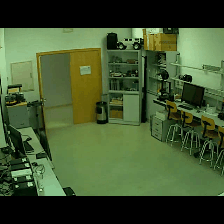

In [ ]:
random_video, random_label = random.choice(all_videos)
#print(random_video.shape)
output_folder = '/content/random_video_frames'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)


def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=-1, keepdims=True)

prediction = model.predict(random_video)
logits = np.array(prediction)
prob = softmax(logits)

predicted_class = np.argmax(prob, axis=-1)
confidence = np.max(prob, axis=-1)

print(f'Classe reale: {random_label}')
print(f'Classe predetta: {predicted_class}, Confidence: {confidence[0]}')

frame_number = 0
num_frames = random_video.shape[1]
frames = []

for i in range(num_frames):
    frame = random_video[0, i]
    #print(frame)
    #print(frame.shape)
    frame = (frame * 255).astype(np.uint8)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    frame_filename = os.path.join(output_folder, f'frame_{frame_number:04d}.jpg')
    cv2.imwrite(frame_filename, frame_rgb)
    frames.append(frame)
    frame_number += 1

#print(random_video.shape)
gif_filename = 'random_video.gif'
imageio.mimsave(gif_filename, frames, fps=5)

from IPython.display import Image

Image(filename=gif_filename)